In [1]:
import numpy as np
import pandas as pd
# np.random.seed(4)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import gym
import random
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
model = Sequential()
model.add(Dense(48, input_shape=(6, ), activation="tanh"))
model.add(Dense(48, activation="relu"))
model.add(Dense(48, activation="tanh"))
model.add(Dense(48, activation="relu"))
model.add(Dense(1, activation="linear"))

Instructions for updating:
Colocations handled automatically by placer.


In [58]:
class DQN():
    
    def __init__(self, model, observation_size, env, alpha=0.01, gamma=0.9, 
                 exploration_params={'epsilon': 1, 'max_epsilon': 1.0, 'epsilon_decay': 0.995},
                 batch_size=30, epochs=20, explore='epsilon', number_of_episodes=50, loss='mse',
                 full_memory_replay=True, set_limit_on_learning=False, learning_render=False):
        
        self.observation_size = observation_size
        self.alpha = alpha
        self.gamma = gamma
        self.exploration_params = exploration_params
        self.batch_size = batch_size
        self.epochs = epochs
        self.env = env
#         self.env._max_episode_steps = game_limit
        self.action_space = list(range(self.env.action_space.n))
        self.number_of_episodes = number_of_episodes
        self.explore = explore
        self.tmp_memory = np.empty((0, self.observation_size+self.env.action_space.n+1))
        self.memory = np.empty((0, self.observation_size+self.env.action_space.n+1))
        self.full_memory = np.empty((0, self.observation_size+self.env.action_space.n+1))
        self.full_memory_replay = full_memory_replay
        self.reward_per_episode = []
        self.set_limit_on_learning = set_limit_on_learning
        self.learning_render = learning_render

        self.model = model
        self.model.compile(loss=loss, optimizer=Adam(lr=self.alpha))
        
        
    def monte_carlo(self, reward_list):
        """
        Value function is calculated by Monte-Carlo technique
        """
        
        q_value_list = []
        for i, _ in enumerate(reward_list):
            q_value_list.append(reward_list[i] + self.gamma*np.sum(reward_list[i+1:]))
          
        return q_value_list
    
    
    def epsilon_greedy(self, state):
        """
        This function is based on simple epsilon greedy technique, chooses action with max q-value
        with epsilon randomness, if uniformly random chosen number is biger than the epsilon number
        action is chosen randomly, otherwise argmax. This is an attemnt to solve exploration-exploitation
        problem.
        """
        
        actions_one_hot = pd.Series(self.action_space)
        actions_one_hot = pd.get_dummies(actions_one_hot)
        _state = np.array(state)
        if np.random.rand() <= self.exploration_params['epsilon']:
            action_q_values = []
           
            
            for a in self.action_space:
                # give to the model to predict q-value for every state action pair
                current_state = np.append(_state, actions_one_hot.iloc[a].values)
                current_state = current_state.reshape((1,-1))
                action_q_values.append(self.model.predict(current_state))
            
            action = np.argmax(action_q_values)
            next_state, re, done, inf = self.env.step(action)
            
            if not done:
                self.tmp_memory = np.append(self.tmp_memory,
                                            [np.append(_state,
                                                       np.array([np.append(actions_one_hot.iloc[action].values, re)]))], axis=0) #np.append(self.tmp_memory,
                
                return False, next_state
                
            else:
                q_s = self.monte_carlo(self.tmp_memory[:, -1])
                
                self.reward_per_episode.append(np.sum(self.tmp_memory[:, -1]))
                self.memory = np.insert(np.delete(self.tmp_memory, -1, 1),
                                len(self.tmp_memory[0])-1, q_s, axis=1)
                
                self.full_memory = np.append(self.full_memory, self.memory, axis=0)
                
                self.tmp_memory = np.empty((0, self.observation_size+len(self.action_space)+1))
                _state = next_state
                
                return True, next_state
           
            
        else:
            if self.exploration_params['epsilon'] <= self.exploration_params['max_epsilon']:
                self.exploration_params['epsilon'] /= self.exploration_params['epsilon_decay']

            action = np.random.choice(self.action_space, 1)[0]
            next_state, re, done, inf = self.env.step(action)
            # decay epcilon with epsilon_decay parameter
            if not done:
                self.tmp_memory = np.append(self.tmp_memory, [np.append(_state, np.array([np.append(actions_one_hot.iloc[action].values, re)]))], axis=0) #np.append(self.tmp_memory,

                return False, next_state

            else:
                q_s = self.monte_carlo(self.tmp_memory[:, -1])
                
                self.reward_per_episode.append(np.sum(self.tmp_memory[:, -1]))
                self.memory = np.insert(np.delete(self.tmp_memory, -1, 1),
                                len(self.tmp_memory[0])-1, q_s, axis=1)
                
                self.full_memory = np.append(self.full_memory, self.memory, axis=0)

                self.tmp_memory = np.empty((0, self.observation_size+len(self.action_space)+1))
                _state = next_state

                return True, next_state
                
    def Boltzman(self, state):
        """
        Boltzman exploration is a technique for exploration-exploitation dillema possible sollution.
        The idea is that every action is chosen randomly by probability.
        This method is almost the Boltzman exploration technique because I used just manualy calculated probability.
        The reason behind it is that when using Softmax I found out that difference between classes is huge, even though
        before softmax it was small, which is predictable.
        """
        actions_one_hot = pd.Series(self.action_space)
        actions_one_hot = pd.get_dummies(actions_one_hot)
        _state = np.array(state)

        action_q_values = []

        for a in self.action_space:
            # give to the model to predict q-value for every state action pair
            current_state = np.append(_state, actions_one_hot.iloc[a].values)
            current_state = current_state.reshape((1,-1))
            action_q_values.append(int(self.model.predict(current_state)))
        
        if sum(action_q_values) == 0:
            action_q_values = list(np.ones(len(action_q_values)))
            
        action_q_values = [0.000001 if i < 0 else i for i in action_q_values]
        
        acts_probs = [x/sum(action_q_values) for x in action_q_values]
        
        
        action = np.random.choice(self.env.action_space.n, 1, p=acts_probs)[0]
        next_state, re, done, inf = self.env.step(action)

        if not done:
            self.tmp_memory = np.append(self.tmp_memory,
                                        [np.append(_state,
                                                   np.array([np.append(actions_one_hot.iloc[action].values, re)]))], axis=0) #np.append(self.tmp_memory,

            return False, next_state

        else:
            q_s = self.monte_carlo(self.tmp_memory[:, -1])

            self.reward_per_episode.append(np.sum(self.tmp_memory[:, -1]))
            self.memory = np.insert(np.delete(self.tmp_memory, -1, 1),
                            len(self.tmp_memory[0])-1, q_s, axis=1)

            self.full_memory = np.append(self.full_memory, self.memory, axis=0)

            self.tmp_memory = np.empty((0, self.observation_size+len(self.action_space)+1))
            _state = next_state

            return True, next_state
    
    def greedy(self, state):
        """
        This function performs greedy policy with 100% probability
        """
        done = False
        actions_one_hot = pd.Series(self.action_space)
        actions_one_hot = pd.get_dummies(actions_one_hot)
        _state = np.array(state)
        action_q_values = []


        for a in self.action_space:
            # give to the model to predict q-value for every state action pair
            current_state = np.append(_state, actions_one_hot.iloc[a].values)
            current_state = current_state.reshape((1,-1))
            action_q_values.append(self.model.predict(current_state))

        action = np.argmax(action_q_values)
        next_state, re, done, inf = self.env.step(action)

        if done:
            return True, next_state
        
        return False, next_state
        
        
    def memory_replay(self):
        
        if self.full_memory_replay:
            
            idx = np.random.randint(len(self.full_memory), size=self.batch_size)
            batch = self.full_memory[idx, :]
            self.model.fit(x=batch[:,:-1], y=batch[:,-1],
                           epochs=self.epochs, verbose=0, shuffle=True)
        
        else:
            self.model.fit(x=self.memory[:,:-1], y=self.memory[:,-1],
                       batch_size=self.batch_size, epochs=self.epochs, verbose=0, shuffle=True)
            
    def plot_progress(self):
        """
        Plots episode cumulative reward, per episode
        """
        episode = list(range(len(self.reward_per_episode)))
        plt.plot(episode, self.reward_per_episode, color='g')
            
        
    def act(self, acting_method='learn'):
        """
        Plays the game based on user preferences - like method of exploration,
        number of episodes (that's all for now, but hopefully will add more features in future)
        """
        
        if acting_method == 'learn':
            
            explore = self.epsilon_greedy
            if self.explore == 'Boltzman':
                explore = self.Boltzman

#             elif self.explore == 'other_method':
#                 explore = self.other_method

            for i in range(self.number_of_episodes):
                timestamp = 0
                done = False
                state = self.env.reset()
                
                print('episode {}'.format(i))
                while not done:
                    if self.learning_render:
                        self.env.render()
                    done, next_state = explore(state)
                    state = next_state
                    if self.set_limit_on_learning:
                        if timestamp == self.env._max_episode_steps-1:
                            self.env.close()
                            print('--------------------------------------------------', i)
                            break
                        timestamp += 1
                    
                self.memory_replay()
                
            self.env.close()
                
                
        elif acting_method == 'act':
            done = False
            state = self.env.reset()
            
            while not done:
                self.env.render()
                done, next_state = self.greedy(state)
                state = next_state
             
            self.env.close()

### Let's try on Cart-pole with epsilon greedy technique

In [68]:
agent = DQN(model=model,observation_size=4, env=gym.make('CartPole-v1'), epochs=10,
                     number_of_episodes=90,
                     alpha=0.001,
                     exploration_params={'epsilon': 0.7,
                                         'max_epsilon': 1.0,
                                         'epsilon_decay': 0.99},
                     gamma=0.999, full_memory_replay=False, set_limit_on_learning=True)

In [69]:
agent.act('learn')

episode 0
episode 1
episode 2
episode 3
episode 4
episode 5
episode 6
episode 7
-------------------------------------------------- 7
episode 8
-------------------------------------------------- 8
episode 9
episode 10
episode 11
-------------------------------------------------- 11
episode 12
episode 13
-------------------------------------------------- 13
episode 14
episode 15
episode 16
episode 17
episode 18
episode 19
-------------------------------------------------- 19
episode 20
-------------------------------------------------- 20
episode 21
-------------------------------------------------- 21
episode 22
-------------------------------------------------- 22
episode 23
episode 24
-------------------------------------------------- 24
episode 25
-------------------------------------------------- 25
episode 26
episode 27
-------------------------------------------------- 27
episode 28
episode 29
episode 30
-------------------------------------------------- 30
episode 31
------------

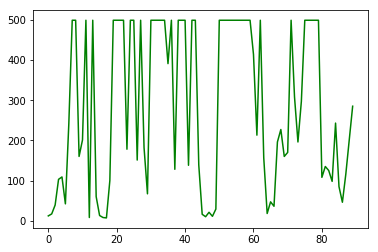

In [70]:
agent.plot_progress()

#### This is the best result for this environment

In [29]:
agent.act('act')

In [ ]:
agent.env.close()

## Now with almost-Boltzman

In [71]:
boltzman_agent = DQN(model=model,observation_size=4, env=gym.make('CartPole-v1'), epochs=10,
                     number_of_episodes=90,
                     alpha=0.01,
                     explore='Boltzman',
                     gamma=0.999, full_memory_replay=False, set_limit_on_learning=True, learning_render=False)

In [72]:
boltzman_agent.act('learn')

episode 0
episode 1
episode 2
episode 3
episode 4
episode 5
episode 6
episode 7
episode 8
episode 9
episode 10
episode 11
episode 12
episode 13
episode 14
episode 15
episode 16
episode 17
episode 18
episode 19
episode 20
episode 21
episode 22
episode 23
episode 24
episode 25
episode 26
episode 27
episode 28
episode 29
episode 30
episode 31
episode 32
episode 33
episode 34
episode 35
episode 36
episode 37
episode 38
episode 39
episode 40
episode 41
episode 42
episode 43
episode 44
episode 45
episode 46
episode 47
episode 48
episode 49
episode 50
episode 51
episode 52
episode 53
episode 54
episode 55
episode 56
episode 57
episode 58
episode 59
episode 60
episode 61
episode 62
episode 63
episode 64
episode 65
episode 66
episode 67
episode 68
episode 69
episode 70
episode 71
episode 72
episode 73
episode 74
episode 75
episode 76
episode 77
episode 78
episode 79
episode 80
episode 81
episode 82
episode 83
episode 84
episode 85
episode 86
episode 87
episode 88
episode 89


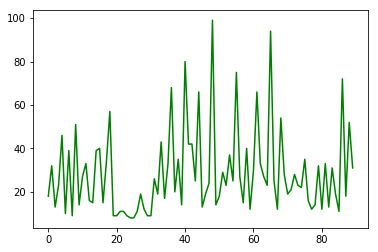

In [73]:
boltzman_agent.plot_progress()

In [74]:
boltzman_agent.act('act')

In [ ]:
boltzman_agent.env.close()

## Time for Lunar-lander

In [75]:
lunar_model = Sequential()
lunar_model.add(Dense(256, input_shape=(12, ), activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(256, activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(256, activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(256, activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(1, activation="linear"))

In [76]:
env_lunar = gym.make('LunarLander-v2')

In [77]:
lunar_agent = DQN(model=lunar_model, env=env_lunar, observation_size=8, epochs=100,
                           number_of_episodes=200,
                           alpha=0.001,
                           explore='Boltzman',
                           gamma=0.999, learning_render=False)

In [78]:
lunar_agent.act('learn')

episode 0
episode 1
episode 2
episode 3
episode 4
episode 5
episode 6
episode 7
episode 8
episode 9
episode 10
episode 11
episode 12
episode 13
episode 14
episode 15
episode 16
episode 17
episode 18
episode 19
episode 20
episode 21
episode 22
episode 23
episode 24
episode 25
episode 26
episode 27
episode 28
episode 29
episode 30
episode 31
episode 32
episode 33
episode 34
episode 35
episode 36
episode 37
episode 38
episode 39
episode 40
episode 41
episode 42
episode 43
episode 44
episode 45
episode 46
episode 47
episode 48
episode 49
episode 50
episode 51
episode 52
episode 53
episode 54
episode 55
episode 56
episode 57
episode 58
episode 59
episode 60
episode 61
episode 62
episode 63
episode 64
episode 65
episode 66
episode 67
episode 68
episode 69
episode 70
episode 71
episode 72
episode 73
episode 74
episode 75
episode 76
episode 77
episode 78
episode 79
episode 80
episode 81
episode 82
episode 83
episode 84
episode 85
episode 86
episode 87
episode 88
episode 89
episode 90
episode 9

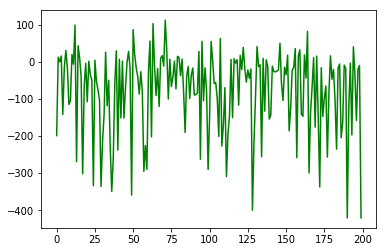

In [79]:
lunar_agent.plot_progress()

The reasons behind such horrible results are the following, if you noticed sometimes the agent preformed preatty well, but afterwards it just crashed, so the first reason is memory replay, I didn't implement full memory replay, the second reason is that model couldn't correctly split actions from each other, because I viewed action as a feature which is not that correct, another reason is that I used Monte-carlo technique to generate the objective, instead I intend to use TD learning, and further maybe TD-lambda, if I'll find it nessesary.

In [80]:
lunar_agent.act('act')

In [ ]:
lunar_agent.env.close()

In [81]:
acrobot_model = Sequential()
acrobot_model.add(Dense(48, input_shape=(9, ), activation="tanh"))
acrobot_model.add(Dense(48, activation="relu"))
acrobot_model.add(Dense(48, activation="tanh"))
acrobot_model.add(Dense(48, activation="relu"))
acrobot_model.add(Dense(48, activation="relu"))
acrobot_model.add(Dense(48, activation="tanh"))
acrobot_model.add(Dense(48, activation="tanh"))
acrobot_model.add(Dense(48, activation="relu"))
acrobot_model.add(Dense(48, activation="tanh"))
acrobot_model.add(Dense(1, activation="linear"))

In [82]:
acrobot_env = gym.make('Acrobot-v1')

In [83]:
acroagent = DQN(model=acrobot_model, env=acrobot_env, observation_size=6, epochs=50,
                           number_of_episodes=100,
                           alpha=0.0004,
                           explore='Boltzman',
                           gamma=0.999, learning_render=False)

In [84]:
acroagent.act('learn')

episode 0
episode 1
episode 2
episode 3
episode 4
episode 5
episode 6
episode 7
episode 8
episode 9
episode 10
episode 11
episode 12
episode 13
episode 14
episode 15
episode 16
episode 17
episode 18
episode 19
episode 20
episode 21
episode 22
episode 23
episode 24
episode 25
episode 26
episode 27
episode 28
episode 29
episode 30
episode 31
episode 32
episode 33
episode 34
episode 35
episode 36
episode 37
episode 38
episode 39
episode 40
episode 41
episode 42
episode 43
episode 44
episode 45
episode 46
episode 47
episode 48
episode 49
episode 50
episode 51
episode 52
episode 53
episode 54
episode 55
episode 56
episode 57
episode 58
episode 59
episode 60
episode 61
episode 62
episode 63
episode 64
episode 65
episode 66
episode 67
episode 68
episode 69
episode 70
episode 71
episode 72
episode 73
episode 74
episode 75
episode 76
episode 77
episode 78
episode 79
episode 80
episode 81
episode 82
episode 83
episode 84
episode 85
episode 86
episode 87
episode 88
episode 89
episode 90
episode 9

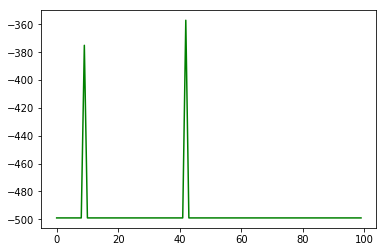

In [85]:
acroagent.plot_progress()

Acrobot performance is a bit more tricky, not because it's a harder problem than Lunar-lander, but because I don't fully understand the reward system for this environment, but hopefuly after implementing all techniques it can achieve good results.

In [ ]:
acroagent.env.close()

In [86]:
acroagent.act('act')